# Generative Shoe Finder – David Ortiz's Workflow

Weaviate Use Case – **Machine Learning Engineer**, June 2024

Powered by 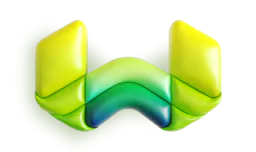 Weaviate

In this use Challenge I am exploring **Weaviate's vector database**. It is one of my first approaches to such products, and also to generative search –or Retrieval Augmented Generation (RAG).

Here we focus on generating a simple use case, that is, **recommending running shoes in simple terms** to people that has no clue of all the brands, models, goals and fits that are out there. I love running, and frequently I get asked all these kind of questions:

* "What are some running shoes that you would recommend me?"
* "My shoes are too narrow, do you know some that do not hurt my feet?"
* "I just want some shoes that are comfortable for everyday training and won't get me injured"
* ...

I guess that, by now, you get the point.

Online forums and chats solve these questions, but just one by one, and they do not make sense off all the information that reviewers drop online. That's why I wanted to create a collection with a few running shoe reviews, to experiment with **a more scalable, LLM-based, approach for niche market understanding**. An approach like this could be applied to many fields in the online media and shopping industry.

For that, I use one **Weaviate Cloud Sandbox**, which is a convenient starting point. I create a modest dataset out of some running shoe reviews from a niche site such as *[Doctors of Running](https://www.doctorsofrunning.com/)*, upload the chunked documents to a collection in WCS, and perform generative search with OpenAI's GPT-4o model to make sense of the information retrieved. 

In this interactive python notebook, you can find all the steps related to **early development and data preparation**. The final output of this challenge is a simple **Streamlit frontend** in their public cloud.

Table of Contents:
* [Setup](#0-setup)
  * [OpenAI Setup](#01-openai-setup)
  * [Weaviate Setup](#02-weaviate-setup)
* [Dataset Scraping](#1-dataset-scraping)
* [Weaviate Database Setup](#2-weaviate-database-creation)
  * [Collection creation](#21-collection-creation)
  * [Data import](#22-database-import)
* [Weaviate Generative search](#3-weaviate-generative-search)


## 0. Setup

A few imports of the libraries we'll be using.

In [342]:
import json
import os
import random
import re
import requests
import time

import weaviate
import weaviate.classes as wvc
from dotenv import load_dotenv
from newspaper import Article
from pathlib import Path
from tqdm import tqdm
from openai import OpenAI

load_dotenv()


DATA_DIR = Path('../data')
REVIEWS_DIR = DATA_DIR / 'reviews'

### 0.1. OpenAI Setup

First, let's test our OpenAI API credentials.

In [12]:
oai_client = OpenAI()

response = oai_client.chat.completions.create(
    model='gpt-4o',
    messages=[
        {"role": "system", "content": "You are a bot that greets nice people, but do not ask questions.."},
        {"role": "user", "content": "Say hi to the folks at Weaviate! ✨"}
    ]
)

response.choices[0].message.content

"Hello to everyone at Weaviate! ✨ Hope you're all having an amazing day!"

### 0.2. Weaviate Setup

Let's also check the connection to WCS.

In [241]:
def get_weaviate_client():
    client = weaviate.connect_to_wcs(
        cluster_url=os.getenv("WCS_DEMO_URL"),
        auth_credentials=weaviate.auth.AuthApiKey(os.getenv("WCS_DEMO_RO_KEY")),
        headers={'X-OpenAI-Api-key': os.getenv("OPENAI_API_KEY")}
    )
    return client


with get_weaviate_client() as client:
    print(f"{'Weaviate is ready! 🚀' if client.is_ready() else 'oh no..'}")

Weaviate is ready! 🚀


## 1. Dataset Scraping

As mentioned, I'm creating my own dataset for this use case.

For that, I manually collect a few (around 30) links to running shoe reviews from the last few months. These links are stored in the `data/shoe-review-selection.txt` file.

Then, I make use of OpenAI to help me get structured data to start the scraping process and local data storage step previous to the import to Weaviate. With that, I can start from some structured data, stored in `data/shoes.json`.

In [254]:
oai_client = OpenAI()


def load_urls_from_file(file_path: Path) -> list[str]:
    """Gets list of reviews to be scrapped from a .txt file"""
    with open(file_path, 'r') as file:
        urls = file.read().splitlines()
    return urls


def get_review_info(review_url: str) -> dict:
    """OpenAI returns a JSON-like object with structured info from the review url"""
    response = oai_client.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": 'You are a helpful assistant designed to output a JSON object just from a link to a shoe review. The JSON schema is as follows: {{"full-name": {{"brand": "string", "model": "string", "review_url": "string"}}}}. Brands should not be fully upercase, just capitalized. Principal key "full-name" is just "brand" + "model".'},
            {"role": "user", "content": "https://www.doctorsofrunning.com/2024/05/new-balance-fuelcell-rebel-v4-review.html"},
            {"role": "assistant", "content": '{{"New Balance FuelCell Rebel v4": {{"brand": "New Balance", "model": "FuelCell Rebel v4", "review_url": "https://www.doctorsofrunning.com/2024/05/new-balance-fuelcell-rebel-v4-review.html"}}}}'},
            {"role": "user", "content": review_url}
        ]
    )
    return json.loads(response.choices[0].message.content)


def process_urls(urls: list[str]) -> None:
    """Creates a global .json with some metadata previous to the scraping process"""
    shoe_selection_info = {}
    for url in tqdm(urls, ascii=True, ncols=100, desc=f'Processing shoe list'):
        # get metadata and include it in the global dictionary
        review_info = get_review_info(url)
        shoe_selection_info.update(review_info)

    with open(DATA_DIR/'shoes.json', 'w') as file:
        json.dump(shoe_selection_info, file, indent=4, sort_keys=True)

    return None


if __name__ == '__main__':
    shoe_selection_urls = load_urls_from_file(DATA_DIR/'shoe-review-selection.txt')
    process_urls(shoe_selection_urls)

Processing shoe list:   0%|                                                  | 0/29 [00:00<?, ?it/s]

Processing shoe list: 100%|#########################################| 29/29 [00:43<00:00,  1.48s/it]


After that, I can do the actual scraping, with the help of `newspaper3k` library. As said, we scrape just a very limited amount of articles, caching them, and with a some waiting time in between requests to the target site.

Each review is stored in its own .txt file in the `data/reviews/` folder, after some minor formatting to remove some annoying adn weird spacing artfacts.

In [233]:
def get_slug(title: str) -> str:
    """Gets slug-like string from model name"""
    return title.lower().replace(' ', '-')


def save_review(product_name: str, text: str) -> None:
    """Stores full review in a single .txt file"""
    cleaned_text = normalize_line_breaks(text)
    title = get_slug(product_name)
    with open(REVIEWS_DIR / f'{title}.txt', 'w') as file:
        file.write(cleaned_text)


def is_scrapped(slug: str) -> bool:
    """Checks if the review was already scrapped"""
    file_path = REVIEWS_DIR / f"{slug}.txt"
    return file_path.is_file()


def scrape_article(url: str) -> str:
    """Scrapes an article, returning its body text"""
    article = Article(url)
    article.download()
    article.parse()
    return article.text


def count_words(string: str) -> int:
    words = re.findall(r'\b\w+\b', string)
    return len(words)


def normalize_line_breaks(text: str) -> str:
    """Removes unnecesary line breaks"""
    text = re.sub(r'\n{2}', '\n', text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    return text.strip()


def scrape_reviews(info_file: str) -> None:
    
    with open(DATA_DIR/info_file, 'r') as file:
        shoe_info = json.load(file)

    # We'll only scrape a review if not available yet
    reviews_to_scrape = [
        full_name for full_name in shoe_info.keys()
        if not is_scrapped(get_slug(full_name))
    ]

    for full_name in tqdm(reviews_to_scrape, ascii=True, ncols=100, desc=f'Scrapping reviews'):
        review_text = scrape_article(shoe_info[full_name]['review_url'])
        save_review(full_name, review_text)
        # let's behave, and wait a bit
        time.sleep(random.uniform(5, 10))


if __name__ == '__main__':

    shoe_info_file = 'shoes.json'
    scrape_reviews(shoe_info_file)


Scrapping reviews:   0%|                                                     | 0/26 [00:00<?, ?it/s]

Scrapping reviews: 100%|############################################| 26/26 [03:39<00:00,  8.45s/it]


Additionally, an image per shoe is collected. In this case, this process is done manually, to ensure consistency between images. These images are stored in `data/images`, and will be displayed only in the frontend application.

## 2. Weaviate Database Creation

### 2.1. Collection creation

I create a simple collection to keep track of our documents. THe properties are the ones we already sorted in the scraping part, as well as the chunked `text`, the `chunk_index`, and a property to potentially store also an `image` of the product.

Even though I could store images in Weaviate itself as a `BLOB`, WCS instances lack image or multimodal search so, to keep things simple and for this limited usecase, I'll just keep them in the data folder.

In [337]:
from weaviate.classes.config import Property, DataType, Configure


with get_weaviate_client() as client:

    if client.collections.exists("ShoeReviews"):
        client.collections.delete("ShoeReviews")

    client.collections.create(
        name="ShoeReviews",
        properties=[
            Property(name="shoe_name", data_type=DataType.TEXT),
            Property(name="slug", data_type=DataType.TEXT),
            Property(name="brand", data_type=DataType.TEXT),
            Property(name="model", data_type=DataType.TEXT),
            Property(name="review_url", data_type=DataType.TEXT),
            Property(name="text", data_type=DataType.TEXT),
            Property(name="chunk_index", data_type=DataType.INT)
        ],
        vectorizer_config=Configure.Vectorizer.text2vec_openai(),
        generative_config=Configure.Generative.openai(
            model="gpt-4-1106-preview"
        )
    )

### 2.2. Database Import

* **Document chunking**: To load the data into the collection and to keep things simple, I'm using a basic fixed-size chunking, to 250 words per chunk, with a 10% overlap. This way, I can provide a good context with only one chunk provided, which keeps things simple in the data manipulation going forward.

In [279]:
def pretty_print(message):
    """Print long strings in a way that isn't terrible to read"""
    paragraphs = re.split(r'\n\n+', message)
    formatted_paragraphs = []
    for paragraph in paragraphs:
        paragraph = paragraph.strip('\n')
        lines = re.findall(r'.{1,100}(?:\s+|$)', paragraph)
        lines = [line.strip() for line in lines]
        formatted_paragraph = '\n'.join(lines)
        formatted_paragraphs.append(formatted_paragraph)
    formatted_message = '\n\n'.join(formatted_paragraphs)
    print(formatted_message)


def word_splitter(source_text: str) -> list[str]:
    """Splits words by any amount of spaces"""
    source_text = re.sub(r"\s+", " ", source_text)
    return re.split(r"\s", source_text)


def get_chunks(text: str, chunk_size: int, overlap_fraction: float) -> list[str]:
    """Split text in fixed sized chunks, with fraction overlap"""
    text_words = word_splitter(text)
    overlap_int = int(chunk_size * overlap_fraction)
    chunks = []
    for i in range(0, len(text_words), chunk_size):
        chunk_words = text_words[max(i - overlap_int, 0): i + chunk_size]
        chunk = " ".join(chunk_words)
        chunks.append(chunk)
    return chunks


def get_review_text(slug: str) -> list[str]:
    """Loads the review text from the .txt file"""
    with open(REVIEWS_DIR/f"{slug}.txt", "r") as file:
        review_text = file.read()
    return review_text

Test the chunking:

In [345]:
def test_chunking(test_slug: str) -> None:
    chunks = get_chunks(
        text=get_review_text(test_slug),
        chunk_size=250,
        overlap_fraction=0.1
        )
    pretty_print(chunks[0])

test_chunking('altra-escalante-racer-2')

Altra Escalante Racer 2 Price: $139.95 at Running Warehouse Weight: 8.8oz, 249g (men's size 9),
6.4oz, 181g (women's size 8) Stack Height: 22 mm / 22 mm Drop: 0mm Shoe Purpose: Zero drop
performance trainer Pros: Well designed, breathable mesh upper, stiffer platform makes this a rare
low drop shoe that may work for those with hallux limitus Cons: Stiff platform makes me feel like I
am fighting the shoe at faster paces, large weight gain over v1 RUNNING SHOE SUMMARY The Altra
Escalante Racer 2 is Altra's lowest stack shoe, designed for faster training and racing. Altra says
the main update to the shoe is a new engineered mesh upper, keeping the 22mm stack height, Altra Ego
midsole, Original FootShape toe box (Altra's widest), and zero drop the same as version 1.
Strangely, according to Altra's website, the women's version has gained 0.7 oz over version 1 and
the men's has gained 2.0 oz, with the men's version 2 weighing 8.8oz and women's 6.4oz. Version 2
has a much stiffer platform tha

* **Document Import**: loop thrhough all documents available, chunking themn and inserting into the `ShoeReviews` collection.

In [338]:
def import_data(all_info_file: str) -> None:
    """Load data into Weaviate collection"""
    
    with open(DATA_DIR/all_info_file, 'r') as file:
        all_shoe_info = json.load(file)

    with get_weaviate_client() as client:
        collection = client.collections.get("ShoeReviews")

        with collection.batch.dynamic() as batch:

            # iterate through all shoe models
            for full_name, shoe_info in tqdm(all_shoe_info.items(), ascii=True, ncols=100, desc=f'Inserting reviews'):
                slug = get_slug(full_name)
                review_text = get_review_text(slug)
                chunks = get_chunks(review_text, chunk_size=250, overlap_fraction=0.1)

                for i, chunk in enumerate(chunks):

                    review_chunk_object = {
                        'shoe_name': full_name,
                        'slug': slug,
                        'brand': shoe_info['brand'],
                        'model': shoe_info['model'],
                        'review_url': shoe_info['review_url'],
                        'text': chunk,
                        'chunk_index': i+1,
                    }
                    
                    batch.add_object(properties=review_chunk_object)


if __name__ == '__main__':
    all_shoes_info_file = 'shoes.json'
    import_data(all_shoes_info_file)

Inserting reviews: 100%|############################################| 29/29 [00:03<00:00,  8.95it/s]


Check a few insertions:

In [344]:
def test_insertions():
    try:
        client = get_weaviate_client()
        reviews = client.collections.get("ShoeReviews")
        for i, item in enumerate(reviews.iterator()):
            print(item.properties)
            if i + 1 == 5:
                break
    finally:
        client.close()

test_insertions()

{'text': 'in. The security is good thanks to the thicker upper and gusseted tongue. I only had to tighten down the midfoot a little and had no other trouble. The upper is comfortable enough that some may be able to use this for sockless running. Due to the thicker toe guard, I would still encourage the use of socks. Typical Size: Men\'s US Size 10 Shoes that have fit Matt well: Saucony Guide 17, ASICS Kayano 30, Hoka Gaviota 5, Saucony Endorphin Elite, Nike Ultrafly Shoes that have fit snug: Hoka Arahi 7, Saucony Kinvara 14 Shoes that have fit large: Salomon S/Lab Phantasm 2, Altra Timp 5 Nathan: This shoe got an overhaul top to bottom, including the upper. When I saw that this shoe moved to PWRRUN PB (more on this later) I certainly expected the shoe to lose some weight. However, it is coming in slightly heavier than it\'s predecessor, which is likely mostly due to the changes in the upper. The change in weight will be discussed more in the "Performance" section, but it in no way wors

And get aggregate counts:

In [340]:
def get_chunk_counts(collection_name: str) -> None:
    try:
        client = get_weaviate_client()
        reviews = client.collections.get(collection_name)

        response = reviews.aggregate.over_all(total_count=True)
        print(f'Total objects in collection {collection_name}: {response.total_count}\n')

        response = reviews.aggregate.over_all(
            group_by=wvc.aggregate.GroupByAggregate(prop="shoe_name")
        )

        print('Top 5 models per chunk count:')
        for i, group in enumerate(response.groups):
            print(f"  {group.grouped_by.value}: {group.total_count}")
            if i+1 == 5:
                break

    finally:
        client.close()

get_chunk_counts('ShoeReviews')

Total objects in collection ShoeReviews: 253

Top 5 models per chunk count:
  Asics Metaspeed Edge Paris: 15
  Mizuno Wave Rebellion Pro 2: 13
  Hoka Cielo X1: 13
  Altra Vanish Carbon 2: 13
  Mizuno Wave Inspire 20: 11


## 3. Weaviate Generative Search

First we can test Weaviate's generative search over our collection, and tune its query and task.

In [349]:
def generative_search(user_query: str):
    try:
        client = get_weaviate_client()
        reviews = client.collections.get('ShoeReviews')

        response = reviews.generate.near_text(
            query=user_query,
            limit=1,  # to keep query and text generation fast and simple
            grouped_task='Recommend the running shoe for which a snippet of text is provided, focusing on what is mentioned there. Very briefly explain why, in just two or three bullet points. You can use markdown. Do not return the shoe name as a bullet point, title or similar.',
            grouped_properties=['shoe_name', 'text'],
            return_metadata=wvc.query.MetadataQuery(distance=True)
        )
        #print(response.generated)

    finally:
        client.close()

    return response.objects[0], response.generated


def get_query_from_toggles(shoe_type: str, runner_profile: str, shoe_property: str, goal: str) -> str:
    query = ''
    query += f"{shoe_type} running shoes " if shoe_type else "running shoes "
    query += f"that are {shoe_property} " if shoe_property else ""
    query += f"for a {runner_profile} runner " if runner_profile else ""
    query += f"to be used for {goal}" if goal else ""

    print(f'{query=}\n')

    return query


def test_generative_search():

    shoe_type = "road"
    runner_profile = "beginner"
    shoe_property = "lightweight"
    goal =  "training"

    search_query = get_query_from_toggles(shoe_type, runner_profile, shoe_property, goal)
    response_object, response_generated = generative_search(search_query)

    print(f"Response text:")
    pretty_print(response_object.properties['text'])
    print(f'\nResponse generated:')
    pretty_print(response_generated)


test_generative_search()

query='road running shoes that are lightweight for a beginner runner to be used for training'

Response text:
to learn to use a drastically different tool while still learning the basics of the support may
prove to be too much for both the runners and their bodies. Complex shoes make things more complex,
which is better later on. When it comes to early learning stages, simple is best at first. For those
reasons, we suggest that new runners consider shoes like the 880v14 or other simple straightforward
shoes like those in our Best Running Shoes for Beginners guide. Learning the basic skills of
running, learning to add some simple strength training exercises a few times a week, learning the
basics of nutrition, sleep and recovery and how to appropriately train will induce far greater
fitness gains than complex shoes. Those can come later but starting simple is best for anything new,
especially running. References:

Response generated:
**Recommended Running Shoe: New Balance Fresh Foam X 

So here we can see both the top result for the vector search, the chunk that was provided to OpenAI, and then the response generated by the model using the task that was provided.

So now let's create a frontend to play with this functionality :)